# Beat Saber - Generated Maps Algorythmically, Mostly For Fun, No Profit

There is this [Beat Sage](https://beatsage.com/) map generator powered by AI that seems to be working well. The results looks fun.

Still, I was curious to see if it would be possible to generate maps through probabilities, based on observed patterns from existing maps.

The strategy was to take existing maps, break them into sequences (2 beats per sequence seems like a good balance), take note of which sequence follows which ones, and then randomly generate new maps based on these known patterns.

That worked well, kind of. What I noticed was that unless mappers reuses the same sequences of blocks, options for the "next sequence" will be quite limited to... the next sequence from that song.

This script end up actually reskining existing maps to new songs, which is still fun, but is far from original new sequences of beats.

The following code demonstrates the approach I took. The result is fun, and was an interesting exercise to understand how maps can be rendered.

In this example, I will use maps created by multipe mappers that I like to play and mainly because their maps tend to have a nice flow:
* [Dee-Dee](https://bsaber.com/members/dee-dee/)
* [Nixie.Korten](https://bsaber.com/members/Nixie.Korten/) 
* [misterlihao](https://bsaber.com/members/misterlihao/)
* [Joetastic](https://bsaber.com/members/joetastic/)
* ... and some more. 

Depending on the tracks that I downloaded from these mappers in my customLevels folder, the results will tend to be quite different. It's possible to train sequences on all maps in the customLevels by adding "" to the filtering list, but this will render inconsistent songs when there is a wide range of music style. Focusing on specific styles seems to work better.

## The results
Here are two examples of songs produced by this code:
* [Big In Japan by Alphaville](https://www.youtube.com/embed/_IYjBCLKmBE) (first version, without lighting effects)
* [Maria - I Like It Loud by Scooter](https://youtu.be/iQaO4YG7Su0)

## How to use this code

[Beastsaber has excellent instructions](https://bsaber.com/getting-started/mapping/) explaining how to prepare an audio file for mapping.

At a high level, the following steps are necessary:
1. Software Setup: Download the necessary tools for mapping: an [audio editor](https://www.audacityteam.org/) and a [map editor](https://bsmg.wiki/mapping/#map-editing-resources).
2. Audio Setup: [Set up your audio file](https://bsmg.wiki/mapping/basic-audio.html), find and confirm the BPM, and export in OGG format.
    * Adding 8 full beat before the song starts gives some time to see the first blocks comming
   
3. Editor Setup & Mapping: Set up your song in your [mapping editor](https://bsmg.wiki/mapping/#community-editors) (we recommend MMA2) and get mapping! Review [basic mapping practices](https://bsmg.wiki/mapping/basic-mapping.html) before you start. [Playtest](https://bsmg.wiki/mapping/#playtesting) your own work early and often.

<- This is where we can insert ourselves in the creation process

4. Lighting: Review [basic lighting information](https://bsmg.wiki/mapping/#lighting-practices). Simple manual lighting is easier than you think!
5. ~Playtesting: Third-party playtesting via the BSMG Discord is highly recommended to get constructive feedback and to get past your own “map blindness.~
6. ~Release Your  Map: Once your song has been mapped, lighted, and playtested you’re ready to release your song to the world on BeatSaver (it will mirror here to BeastSaber in a few minutes).~

^ About the two last steps: the result will be quite random, and not worthy of standing along all the great work from real mappers. 

## Loading Libraries

In [1]:
# pip install -r requirements.txt

import json
import random
from os.path import exists
import os
import time
import copy

import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wavfile

import math
import soundfile as sf

start_time = time.time()

## Configuration

Location of the customeLevels and WIP levels, as well as the difficulty used for training

In [2]:
customLevels_folder = "/mnt/c/Program Files/Oculus/Software/Software/hyperbolic-magnetism-beat-saber/Beat Saber_Data/CustomLevels/"
customWIPLevels_folder = "/mnt/c/Program Files/Oculus/Software/Software/hyperbolic-magnetism-beat-saber/Beat Saber_Data/CustomWIPLevels"

assert exists(customLevels_folder) == True, f"customLevels folder {customLevels_folder} should exists"
assert exists(customWIPLevels_folder) == True, f"customWIPLevels folder {customWIPLevels_folder} should exists"

## Songs used for training

For this, I am searching for folders in the customeLevels folder, and uses any song matching one of listed keywords

In [3]:
# MODIFY ME

difficulty = "ExpertStandard.dat"

# This is where I define filters for songs. Using the mapper's name works well
filters = ["dee", "nixie", "joetastic", "faded", "ge2toro", "nitronik", "misterlihao", "majorpickle"]

## Queue of Songs to map

While I define each functions used by this code, I will be using the first entry of the song queue for testing and demonstratation.

In reality, the mapping is done in two parts:
1. Training on existing maps. This only needs to be done once
2. Mapping of new songs.

For this last part, the code will be going through the `song_queues` variable defined in the next cell, and will map each of them.

The reason why I am doing this is that it makes it easier to add a new song to map, while still keeping the parameters of the files I mapped previously.

The difficulty is defined only once, so are the song used for training. Otherwise the code would need to retrain for each songs, which might be suitable if I want to use different style of maps as a template, but is quite time consuming if I am going to try to find the best match against the output audio.

The inconvenient of the current method is that if I train on maps that are inconsistent, so will be the output maps. It's likely that there will be super slow portions, followed by crazy fast sequences because of the sequences used for training.

In [4]:
# MODIFY ME

song_queues = [
    { "folder": "Alphaville - Big In Japan - 97.79", "first_beat": 16, "last_beat": 368 },
    { "folder": "Scooter - Maria (I Like It Loud)", "first_beat": 8, "last_beat": 510 },
    { "folder": "Vanilla Ice - Ice Ice Baby", "first_beat": 8, "last_beat": 505 },
    { "folder": "Les Rita Mitsouko - C'est comme ça", "first_beat": 8, "last_beat": 848 },
    { "folder": "Ramasutra - Marder", "first_beat": 34, "last_beat": 602 },
    { "folder": "Les Trois Accords - Bamboula", "first_beat": 8,"last_beat": 540},
]

## Configuring Sequence Length and Precision

In [5]:
# probably ok to leave me unmodified

# uses two beats for one sequence of blocks
# longer sequences (ex.: 4) reduces the randomness since it reduces the potential possibility of 
# chaining sequences
sequence_length = 2

# precision: break each beat in 8 parts. 1/8 of a beat. necessary for fast songs. 
# having this too low could cause block overlay
precision = 16

## Extracting the list of all files that will be used for training

In [6]:
def get_list_map_files(customLevels_folder, filters):
    filters_lower = [x.lower() for x in filters]
    return sorted(list(set([
        x for x in os.listdir(customLevels_folder)
        if any(y in x.lower() for y in filters_lower)
    ])))


notes_files = get_list_map_files(customLevels_folder, filters)
assert len(notes_files) > 0, "There are no training files. check your `customerLevels_folder`, or your `filters` variable"
print('Number of songs used for training:', len(notes_files))
# notes_files

Number of songs used for training: 78


## Confirming configurations

In [7]:
def open_file_info(current, customWIPLevels_folder):
    output_file = "{}/{}/{}".format(customWIPLevels_folder, current['folder'], difficulty)
    output_info_dat_file = "{}/{}/Info.dat".format(customWIPLevels_folder, current['folder'])
    assert exists(output_info_dat_file), f"info file should exists in the song_output_folder" 
    assert exists(output_file), f"output file {current['folder']}/{difficulty} should exist"

    new_config = copy.copy(current)
    
    with open(output_info_dat_file) as f:
        song_key = "_songFilename"
        bpm_key = "_beatsPerMinute"
        song_file_key = "_songFilename"
        info_dat = json.load(f)
        song_file_name = info_dat[song_file_key]
        audio_file = "{}/{}/{}".format(customWIPLevels_folder, current['folder'], song_file_name)
        
        new_config['config'] = {
            'output_file': output_file,
            'output_info_dat_file': output_info_dat_file,
            'info_dat': info_dat,
            'song_key': song_key,
            'bpm_key': bpm_key,
            'song_file_key': song_file_key,
            'song_file_name': song_file_name,
            'audio_file': audio_file
        }
        
        return new_config

current1 = open_file_info(song_queues[0], customWIPLevels_folder)

# print("* checking that the song file exists in the song_output_folder")
assert exists(current1['config']['audio_file']), f"song file {current1['config']['info_dat']['song_file_key']} should exist"

# print("* checking that the _beatsPerMinute value is configured")
assert current1['config']['bpm_key'] in current1['config']['info_dat'].keys(), f"key {current1['config']['bpm_key']} should be in current1['config']['info_dat'].keys(): {current1['config']['bpm_key'] in current1['config']['info_dat'].keys()}"
assert current1['config']['info_dat']["_beatsPerMinute"] > 0.0, f"{current1['config']['bpm_key']} should have a value greater than zero: {info_dat[bpm_key]}"

# the info.dat file looks like this
current1['config']['info_dat']

{'_version': '2.0.0',
 '_songName': 'Big In Japan',
 '_songSubName': '',
 '_songAuthorName': 'Alphaville',
 '_levelAuthorName': 'unknow',
 '_beatsPerMinute': 97.79000091552734,
 '_shuffle': 0,
 '_shufflePeriod': 0.5,
 '_previewStartTime': 12,
 '_previewDuration': 10,
 '_songFilename': 'song.ogg',
 '_coverImageFilename': 'cover.jpg',
 '_environmentName': 'PanicEnvironment',
 '_songTimeOffset': 0,
 '_customData': {'_contributors': [],
  '_editors': {'MMA2': {'version': '4.8.4'}, '_lastEditedBy': 'MMA2'}},
 '_difficultyBeatmapSets': [{'_beatmapCharacteristicName': 'Standard',
   '_difficultyBeatmaps': [{'_difficulty': 'Expert',
     '_difficultyRank': 7,
     '_beatmapFilename': 'ExpertStandard.dat',
     '_noteJumpMovementSpeed': 16,
     '_noteJumpStartBeatOffset': 0,
     '_customData': {'_editorOffset': 0,
      '_editorOldOffset': 0,
      '_warnings': [],
      '_information': [],
      '_suggestions': [],
      '_requirements': []}}]}]}

## Intro to Beat Saber Data Files: How Blocks Are Encoded

ExpertStandard.dat is a JSON file, and contains multiple sections. The one that is interesting is the "_notes" section, which contains a long series of entries like the folowing:

In [8]:
sample_block = {
  "_time" : 25.5,
  "_lineIndex" : 3,
  "_lineLayer" : 1,
  "_type" : 1,
  "_cutDirection" : 0
}

The `_time` key identifies the beat where that specific entry will show up.

The following lines are a bit more cryptic, but here is a lookup table, and with which charactor I translate them when I flatten each block for processing.


Columns. translated by the idx directly
* _lineIndex: 0 "far left column"
* _lineIndex: 1 "center left column"
* _lineIndex: 2 "center right column"
* _lineIndex: 3 "far right column"

Layer. translated by the first column of letters on my keyboard
* _lineLayer: 0 "bottom" "z"
* _lineLayer: 1 "middle" "a"
* _lineLayer: 2 "top" "q"

Block type. 
* _type: 0 "red" "r"
* _type: 1 "blue" "b"
* _type: 3 "bomb" "x"

Cut Direction. I don't have a numeric keypad on my keyboard, so I used the left secton to represent them.
* _cutDirection: 0 "up" w
* _cutDirection: 1 "down" x
* _cutDirection: 2 "left" a
* _cutDirection: 3 "right" d
* _cutDirection: 4 "up left"  q
* _cutDirection: 5 "up right" e
* _cutDirection: 6 "down left" z
* _cutDirection: 7 "down right" c
* _cutDirection: 8 "all" s


## How Lighting is encoded

The lighting track (`_events` key in the ExpertStandard.dat JSON file) is a lot more complex than the `_notes` track.

A single lighting event looks like this:

In [9]:
sample_light = {
    "_time": 52.5,
    "_type": 1,
    "_value": 5,
}

The pairs of `_type` and `_value` maps to specific conditions, which looks like this

![beat_saber_lighting_track.png](./beatsaber_map_generator_files/beat_saber_lighting_track.png)

A major difference with the blocks is that some of these lights are toggles. They will go on, and stay on until they are turned off, which makes it harder train on since a certain light might be turned off a few sequences later, completely out of context with when it was activated.

## Function that translates the nodes into a pattern string

In [10]:
layer = "zaq"
colour = "rb?x"
cut_dir = "wxadqezcs"

lighting_type = "abcdefghijklmnopqrstuvwxyz1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ"
lighting_value = "abcdefghijklmnopqrstuvwxyz1234567890ABCDEFGHIJKLMNOPQRSTUVWXYZ"

def encode_block(note, light):
    global layer, colour, cut_dir, lighting_type, lighting_value
    
    seq = (
        str(note["_lineIndex"]) 
        + layer[note["_lineLayer"]] 
        + colour[note["_type"]] 
        + cut_dir[note["_cutDirection"]]
    )

    if light != False:
        seq = seq + lighting_type[light['_type']] + lighting_value[min(light['_value'], len(lighting_value)-1)]
    else:
        seq = seq + lighting_type[random.randint(0,5)] + lighting_value[0]
    
    return seq

def decode_pattern(base, precision, seq):
    global layer, colour, cut_dir
    seqs = json.loads(seq)
    outputs = [] 
    
    for i in range(len(seqs)):
        for j in range(len(seqs[i])):
            outputs.append({
                "_time": base+(i/precision),
                "_lineIndex": int(seqs[i][j][0]),
                "_lineLayer": layer.index(seqs[i][j][1]),
                "_type": colour.index(seqs[i][j][2]),
                "_cutDirection":  cut_dir.index(seqs[i][j][3])            
            })
    return outputs

def decode_lighting(base, precision, seq):
    global lighting_type, lighting_value
    seqs = json.loads(seq)
    lights = []
    
    for i in range(len(seqs)):
        for j in range(len(seqs[i])):
            lights.append({
                "_time": base+(i/precision),
                "_type": lighting_type.index(seqs[i][j][4]),
                "_value": lighting_value.index(seqs[i][j][5])
            })
    return lights

assert encode_block(sample_block, sample_light) == "3abwbf", f"the output from encoding isn't matching expectations"
assert json.dumps(decode_pattern(sample_block['_time'], precision, '[["3abwbf"]]')) == json.dumps([sample_block]), f"decoded pattern isn't matching the original block"
assert json.dumps(decode_lighting(sample_light['_time'], precision, '[["3abwbf"]]')) == json.dumps([sample_light]), f"decoded pattern isn't matching the original block"


## Turning off the lights at the end of the song

In [11]:
def turnoff_lights(beat):
    sequences = []
    for i in [0, 1, 2, 3, 4, 12, 13]:
        sequences.append(
            {
                "_time": beat,
                "_type": i,
                "_value": 0
            }
        )
    return sequences

## Training functions

In [12]:
def count_patterns(sequence):
    blocks = 0
    for i in sequence:
        blocks += len(i)
    return blocks

def check_integrity(current):
    global sequence_length
    global precision
    
    if len(current) == sequence_length * precision:
        return True
    
    print(f"failed: {len(current)} vs {sequence_length * precision}")
    return False

def remember_patterns(track, sequence_length, precision, track_name = ""):
    global following
    global encoded_song
    
    previous_pattern = ""

    for i in range(len(track)):
        if check_integrity(track[i]):
            current_pattern = json.dumps(track[i])
            
            if file not in encoded_song.keys():
                encoded_song[file] = []
                
            encoded_song[file].append(current_pattern)
        
            if previous_pattern not in following.keys():
                following[previous_pattern] = []

            if count_patterns(track[i]) > 0:
                following[previous_pattern].append(current_pattern)     
                previous_pattern = current_pattern 
        else:
            print("current pattern failed the integrity test:", current_pattern)
            raise

## File processing functions

In [13]:
def read_track_file(base_folder, song_output_folder, difficulty_file):
    filename = "{}/{}/{}".format(base_folder, song_output_folder, difficulty_file)
    
    if exists(filename):
        with open(filename) as f:
            return json.load(f)
    
    # print("( ) file '{}/{}' not found. skipping folder".format(song_output_folder, difficulty_file))
    return False

def find_lighting_for_note(lightings, t):
    for event in lightings:
        if event['_time'] > t:
            return False
        elif event['_time'] == t:
            return event
    
    return False

def convert_json_to_patterns(file, sequence_length, precision, content):
    if "_notes" not in content.keys() or "_events" not in content.keys():
        # print("( ) this is a new song with arks:", file)
        return False
    
    first_note = math.floor(content["_notes"][0]["_time"])
    last_note = content["_notes"][-1]["_time"]
    
    nb_sequence = int(((last_note - first_note)) / sequence_length)+1
    
    # print("(+) file: {}, first_note: {}, last_note: {}, precision: {}, nb_sequences: {}".format(
    #   file, first_note, last_note, precision, nb_sequence
    # ))
    
    # initializing an empty list that will keep track of the notes
    track = [[[] for y in range(sequence_length * precision)] for x in range(int(nb_sequence))]
    
    for note, block in enumerate(content["_notes"]):
        index = int(block["_time"])
        subindex = int((block["_time"] - index) * precision)
        idx = (index - first_note) * precision + subindex
        seq = idx//(sequence_length*precision)
        pos = idx%(sequence_length*precision)

        encoded = encode_block(block, find_lighting_for_note(content["_events"], block["_time"]))
        try:
            track[seq][pos].append(encoded)
        except:
            print(filename, note, seq, pos, idx, block)
            raise
            
    return track
        

def process_file(folder, file, difficulty, precision, sequence_length):
    notes_json = read_track_file(folder, file, difficulty)
    
    if notes_json != False:
        track = convert_json_to_patterns(file, sequence_length, precision, notes_json)
        
        if track != False:
            remember_patterns(track, sequence_length, precision, file)

## Song processing

This section goes through all training files and register transitions in the `following` global variable.

The `encoded_song` variable will contain the complete encoded songs. This is useful to find out which sequence comes from what maps later on.

In [14]:
following = {}
encoded_song = {}

for file in notes_files:
    process_file(customLevels_folder, file, difficulty, precision, sequence_length)

## Audio File Analysis

This sections is an attempt to naively detect variations in the song. Using these variations, we can compare them against potential following sequences of blocks, and see which one might be a better fit given the density of the noise.

In [15]:
def load_audio(audio_file):
    audio_file_wav = audio_file + ".wav"

    data, samplerate = sf.read(audio_file)
    if not exists(audio_file_wav):
        sf.write(audio_file_wav, data, samplerate)

    Fs, aud = wavfile.read(audio_file_wav)

    # once the audio file is processed, we don't need the wave file anymore.
    if exists(audio_file_wav):
        os.remove(audio_file_wav)
    return (Fs, aud)


Fs, aud = load_audio(current1['config']['audio_file'])
assert Fs == 44100, f"Audio File ${current1['config']['audio_file']} converted to wave is not 44100hz"
assert len(aud) > 0, f"Audio extract is empty"

print(Fs, len(aud))

44100 10313147



## spectogram of the left channel

/home/simon/.virtualenvs/py38/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7553: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


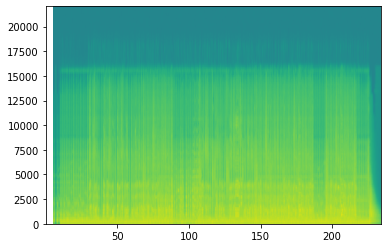

Folder: Alphaville - Big In Japan - 97.79
file: song.ogg
bpm: 97.79000091552734
bps: 1.6298333485921224
seconds per beat: 0.6135596629335244
audio samples per beat: 27057


In [16]:
def get_rythme(current, Fs, aud):
    song_bpm = current["_beatsPerMinute"]
    rythme = {
        'song_bpm': song_bpm,
        'song_bps': song_bpm/60,
        'song_spb': 60/song_bpm,
        'sample_per_beat': int(Fs * 60/song_bpm),
        'audio': aud[:,0] # select left channel only
    }
    powerSpectrum, frequenciesFound, time_val, imageAxis = plt.specgram(rythme['audio'], Fs=Fs)
    plt.show()
    
    return rythme

rythme = get_rythme(current1['config']['info_dat'], Fs, aud)
assert rythme['song_bpm'] > 0, "Song bpm should be greater than 0"
assert rythme['sample_per_beat'] > 0, "sample_per_beat should be greater than 0"
assert len(rythme['audio']) > 0, "rythme['audio'] should contain the decoded audio track"

print(f"Folder: {current1['folder']}")
print(f"file: {current1['config']['song_file_name']}")
print(f"bpm: {rythme['song_bpm']}")
print(f"bps: {rythme['song_bps']}")
print(f"seconds per beat: {rythme['song_spb']}")
print(f"audio samples per beat: {rythme['sample_per_beat']}")

In [17]:
def get_audio_ranges(aud_left, sample_per_beat, precision):
    positive_aud_left = [abs(x) for x in aud_left]

    range3 = max(positive_aud_left)
    range0 = range3 // 10

    break_down = []

    for beat in range(int(len(positive_aud_left)/sample_per_beat)):
        for p in range(precision):
            boundary_left = int((beat * sample_per_beat) + (p * (sample_per_beat/precision)))
            boundary_right = int(boundary_left + ((p+1) * (sample_per_beat/precision)))

            noise_left = int(np.mean(positive_aud_left[boundary_left:boundary_right]))

            break_down.append(int(noise_left//range0))
            
    return range0, range3, break_down

range0, range3, break_down = get_audio_ranges(rythme['audio'], rythme['sample_per_beat'], precision)
assert range0 > 0, "range0 should be greater than 0"
assert range3 > 0, "range3 should be greater than 0"
assert len(break_down) > 0, "the break_down variable should not be empty"

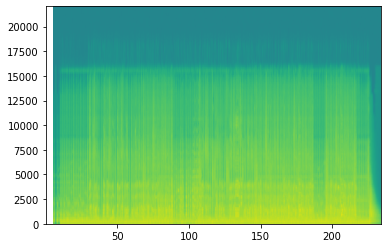

In [18]:
def trim_audio(current, precision, Fs, aud):
    rythme = get_rythme(current['config']['info_dat'], Fs, aud)
    range0, range3, break_down = get_audio_ranges(rythme['audio'], rythme['sample_per_beat'], precision)
    
    return break_down[current['first_beat']*precision:]


trimmed_intensity = trim_audio(current1, precision, Fs, aud)
assert len(trimmed_intensity) < len(break_down), "trimmed_intensity should be smaller than break_down"

In [19]:
print('beginning...')
print(break_down[:current1['first_beat']*(precision)], '*', break_down[current1['first_beat']*precision:(current1['first_beat']*sequence_length*precision)])
print('...end')
print(break_down[-(current1['last_beat']*precision):current1['last_beat']], '*', break_down[-current1['last_beat']:])

beginning...
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1] * [2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1,

## Selecting the best sequence candidate compared to the song intensity

The method used is trying to generate collisions between the audio intensity and potential candidates. The higher the number of collisions, the more likely the intensity should match.

At the same moment, we should be trying to find the sequence that better match the intensity of the audio, so the difference between the candidate and the intensity should be the lowest as possible.


Here is an example of audio intensity calculated earlier.
`[3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2]`

The candidate sequences are converted in number of blocks per step. One block = 1, 2 blocks (blue or red) = 2, etc.
```
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0]
[1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0]
[1 0 0 0 1 0 1 0 0 0 1 0 0 0 0 0]
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0]
[1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0]
[1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0]
```

By multiplying one array by the other, and calculating the sum of the results, we can get a amplitude value. 
By substracting the amplitude to the sequences from a candidate, we get a proximity score

The higher the value of sum(amplitude) - sum(proximity) should indicate a good match.

Here are three examples:

In [20]:
audio_sequence = [3, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 2]
bad_candidate = [1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
best_candidate = [1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]
good_candidate = [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

def test_selection(audio_sequence, candidate):
    a = np.array(audio_sequence)
    c = np.array(candidate)
    
    r = a * c
    p = c - a
    
    print('audio intensity:', a)
    print('* candidate:', c)
    print('* amplification of the result:', r)
    print('* proximity of the amplitude:', p)
    print('* sum of the results (score):', sum(r) - sum(p))
    print('\n')


test_selection(audio_sequence, bad_candidate)
test_selection(audio_sequence, good_candidate)
test_selection(audio_sequence, best_candidate)
    

audio intensity: [3 4 2 2 2 2 2 2 2 2 2 3 3 3 2 2]
* candidate: [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
* amplification of the result: [3 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
* proximity of the amplitude: [-2 -4 -2 -2 -2 -2 -2 -2 -1 -2 -2 -3 -3 -3 -2 -2]
* sum of the results (score): 41


audio intensity: [3 4 2 2 2 2 2 2 2 2 2 3 3 3 2 2]
* candidate: [2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
* amplification of the result: [6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
* proximity of the amplitude: [-1 -4 -2 -2 -2 -2 -2 -2 -2 -2 -2 -3 -3 -3 -2 -2]
* sum of the results (score): 42


audio intensity: [3 4 2 2 2 2 2 2 2 2 2 3 3 3 2 2]
* candidate: [1 0 0 0 1 0 1 0 0 0 1 0 0 0 1 0]
* amplification of the result: [3 0 0 0 2 0 2 0 0 0 2 0 0 0 2 0]
* proximity of the amplitude: [-2 -4 -2 -2 -1 -2 -1 -2 -2 -2 -1 -3 -3 -3 -1 -2]
* sum of the results (score): 44




In [21]:
def find_origins(selected):
    sources = []
    
    for key in encoded_song.keys():
        c = encoded_song[key].count(selected)
        if c > 0:
            if key not in sources:
                sources.append(key)
            
    return sources

def number_successors(candidates, array):
    global following
    counts = [0] * len(candidates)
    
    for i, s in enumerate(candidates):
        if array[s] in following.keys():
            counts[i] = len(following[array[s]])
        
    return counts

def add_bookmark(song, beat):
    return {
        "_time": beat,
        "_name": song
    }

def guess_origin(last_source, sources, known_sources):
    
    if last_source not in sources:
        most_likely_song = ""
        most_likely_count = -1

        for s in sources:
            c = known_sources.count(s) 
            if c > most_likely_count:
                most_likely_count = c
                most_likely_song = s
    return most_likely_song

In [22]:
def select(array, audio_sample):    
    best_fits = []
    
    np_audio_sample = np.array(audio_sample)
    
    for i, a in enumerate(array):    
        decoded = json.loads(a)
        candidates = np.array([len(x) for x in decoded])

        amplification = candidates[:len(np_audio_sample)] * np_audio_sample
        proximity = candidates[:len(np_audio_sample)] - np_audio_sample
        best_fits.append(sum(amplification) - sum(proximity))

    
    candidates = [i for i in range(len(best_fits)) if best_fits[i] == max(best_fits)]
    forward_checks = number_successors(candidates, array)
    electables = [candidates[i] for i in range(len(candidates)) if forward_checks[i] > 0]
    if len(electables) == 0:
        elected = random.choice(candidates)
    else: # this case happens when there is no candidate with a following sequence. the code will recover later
        elected = random.choice(electables)

    if False:
        print(audio_sample)
        print(elected)
        print(len(array), max(best_fits), len(candidates), 'elected:', elected)
    
    return array[elected]

## saving the generated sequence in the output track file.

If it crashes here because the output file does not exists, you might need to generate it by added on random block to the level in MMA2, then save. The file isn't created until something is added to it.

In [23]:
def save_output(output_file, new_track, new_lights, new_bookmarks):    
    with open(output_file) as f:
        output_song = json.load(f)

    output_song["_notes"] = new_track
    output_song["_events"] = new_lights
    
    if "_customData" not in output_song.keys():
        output_song[_customData] = {}
    
    output_song["_customData"]["_bookmarks"] = new_bookmarks

    with open(output_file, 'w') as f:
        f.write(json.dumps(output_song))


## generating the sequence of blocks for the song.

This is where we generate the sequence of blocks.

The `base` is the `first_beat`, and it will continue to select sequences of blocks until it reaches the `last_beat`.
These two variables are defined at the top of the notebook, and need to be configured manually. They can be found by matching the beats to the audio in Mediocre Map Assistant 2 (MMA2). Since the loop generates sequences of `sequence_length` (normally 2 beats), it might be necessary to manually add or delete blocks at the end.

The loop starts by setting the `current_pattern` to blank, the code will select the opening sequences (based on the training songs) that better matches the current audio intensity.

The selected sequence will be checked against potential following sequences (variable `following` trained earlier). If somehow there is no known following sequence to the current_pattern, then the code will recover by selecting a new pattern from the opening ones.

Total Training Time: 23.43 seconds
Alphaville - Big In Japan - 97.79


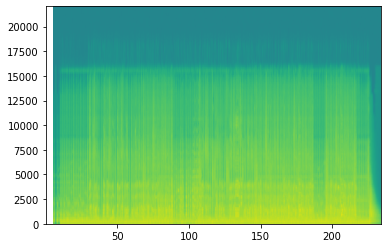

	random seed: 27057 -61481
	Origin of the sequences:
		52.5%: 22e63 (くうになる - misterlihao)
		0.6%: 260d1 (えすけーぷ - misterlihao)
		46.9%: 27ca5 (No Time - nitronik.exe)
	Bookmarks
		beat 16: 27ca5 (No Time - nitronik.exe)
		beat 182: 22e63 (くうになる - misterlihao)
		beat 368: FIN
	Song rendering time: 7.32 seconds
Scooter - Maria (I Like It Loud)


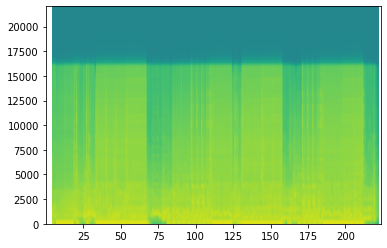

	random seed: 27057 11787999
	Origin of the sequences:
		42.6%: 27a7d (Calabria - DeeDee)
		57.4%: 65c9 (Sweet Dreams (Are Made Of This) - Joetastic)
	Bookmarks
		beat 8: 65c9 (Sweet Dreams (Are Made Of This) - Joetastic)
		beat 296: 27a7d (Calabria - DeeDee)
		beat 510: FIN
	Song rendering time: 6.84 seconds
Vanilla Ice - Ice Ice Baby


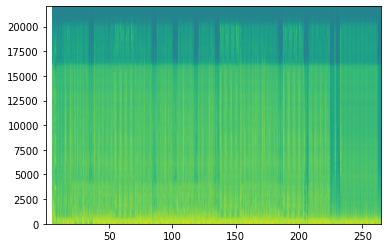

	random seed: 27057 -344288
	Origin of the sequences:
		100.0%: 28efd (Contigo - Faded 99)
	Bookmarks
		beat 8: 28efd (Contigo - Faded 99)
		beat 506: FIN
	Song rendering time: 8.22 seconds
Les Rita Mitsouko - C'est comme ça


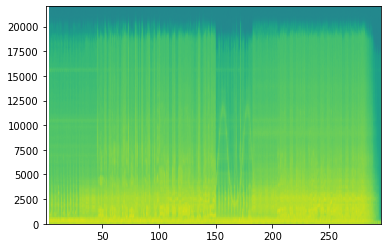

	random seed: 27057 996495
	Origin of the sequences:
		8.1%: 1f767 (アリスブルー - misterlihao)
		6.3%: 20fc6 (Horizon - Ge2toro)
		1.6%: 21307 (ただ声一つ - misterlihao)
		0.4%: 21333 (全部君のせいだ - misterlihao)
		0.2%: 2142b (Graveyard Shift - Ge2toro)
		0.2%: 21979 (フクロウさん - misterlihao)
		24.4%: 250af (うらたねこ♀ - misterlihao)
		0.4%: 2528b (おにけもだんす - misterlihao)
		0.7%: 254a8 (感情ディシーブ - misterlihao)
		24.6%: 27593 (推し変なんて許さない！ - misterlihao)
		19.7%: 27ca5 (No Time - nitronik.exe)
		0.2%: 28c6b (Lean On Me - Faded 99)
		1.3%: 28dfe (愛のモンスター - misterlihao)
		11.9%: 65c9 (Sweet Dreams (Are Made Of This) - Joetastic)
	Bookmarks
		beat 8: 27593 (推し変なんて許さない！ - misterlihao)
		beat 228: 20fc6 (Horizon - Ge2toro)
		beat 276: 1f767 (アリスブルー - misterlihao)
		beat 278: 28dfe (愛のモンスター - misterlihao)
		beat 286: 1f767 (アリスブルー - misterlihao)
		beat 324: 27ca5 (No Time - nitronik.exe)
		beat 500: 1f767 (アリスブルー - misterlihao)
		beat 526: 250af (うらたねこ♀ - misterlihao)
		beat 742: 65c9 (Sweet Dreams (Are Made Of Thi

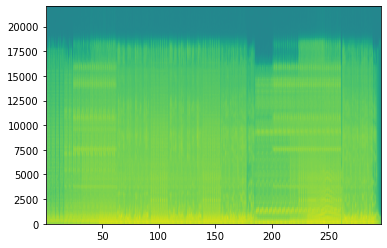

	random seed: 27057 -347426
	Origin of the sequences:
		0.3%: 205d1 (くうになる - misterlihao)
		1.9%: 20fc6 (Horizon - Ge2toro)
		1.0%: 21307 (ただ声一つ - misterlihao)
		0.6%: 22846 (バニー - misterlihao)
		0.3%: 22ee8 (Bones - Faded 99)
		0.3%: 240f4 (Loco - Dee-Dee)
		0.6%: 250af (うらたねこ♀ - misterlihao)
		29.2%: 2528b (おにけもだんす - misterlihao)
		1.3%: 254a8 (感情ディシーブ - misterlihao)
		32.4%: 259b9 (La Funka - Majorpickle)
		1.3%: 25a6b (Supersonic - Dee-Dee)
		20.2%: 26408 (Grime Thing - nitronik.exe)
		10.6%: 2923d (あの夏の旋律へ - misterlihao)
	Bookmarks
		beat 34: 22846 (バニー - misterlihao)
		beat 36: 26408 (Grime Thing - nitronik.exe)
		beat 160: 2528b (おにけもだんす - misterlihao)
		beat 338: 259b9 (La Funka - Majorpickle)
		beat 532: 2923d (あの夏の旋律へ - misterlihao)
		beat 596: 20fc6 (Horizon - Ge2toro)
		beat 602: FIN
	Song rendering time: 9.27 seconds
Les Trois Accords - Bamboula


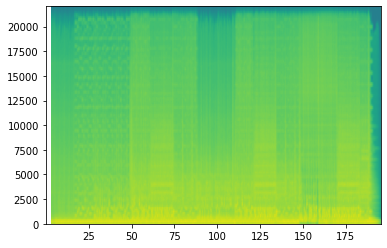

	random seed: 27057 1304484
	Origin of the sequences:
		0.4%: 21333 (全部君のせいだ - misterlihao)
		82.6%: 22e63 (くうになる - misterlihao)
		0.4%: 24f18 (和音 - misterlihao)
		0.7%: 260d1 (えすけーぷ - misterlihao)
		15.9%: 270ed (WOW BB - DeeDee)
	Bookmarks
		beat 8: 22e63 (くうになる - misterlihao)
		beat 454: 270ed (WOW BB - DeeDee)
		beat 540: FIN
	Song rendering time: 6.45 seconds


In [24]:
print("Total Training Time: {:0.2f} seconds".format(time.time() - start_time))

def generate_seed(aud, filename, sample_per_beat):
    seed = np.array(aud[len(aud)//len(filename)-sample_per_beat:len(aud)//len(filename)+sample_per_beat]).sum()
    print(f"\trandom seed: {sample_per_beat} {seed}")
    return seed   
    
def extract_audio_sample(beat, precision, sequence_length, trimmed_intensity):
    l = beat * precision * sequence_length
    r = (beat+1) * precision * sequence_length
    return trimmed_intensity[l:r]
    
    
for song in song_queues:
    start_time = time.time()
    
    match_stats = []
    last_source = False
    
    current_song = open_file_info(song, customWIPLevels_folder)
    
    print(f"{current_song['folder']}")
    
    Fs, aud = load_audio(current_song['config']['audio_file'])
    trimmed_intensity = trim_audio(current_song, precision, Fs, aud)

    
    random.seed(generate_seed(aud, current_song['folder'], rythme['sample_per_beat']))
    
    base = current_song['first_beat']
    current_pattern = ""
    beat = 0
    new_track = []
    new_lights = []
    new_bookmarks = []
    
    while base < current_song['last_beat']:    
        audio_sample = extract_audio_sample(beat, precision, sequence_length, trimmed_intensity)

        if current_pattern in following.keys():
            pattern = select(following[current_pattern], audio_sample)
        else:
            pattern = select(following[""], audio_sample)

        sources = find_origins(pattern)
        if last_source not in sources:
            most_likely_song = guess_origin(last_source, sources, match_stats)
            new_bookmarks.append(add_bookmark(most_likely_song, base))
            last_source = most_likely_song
        match_stats = match_stats + sources     
        
        # add block patern to the new track
        decoded = decode_pattern(base, precision, pattern)        
        new_track = new_track + decoded

        # add the light pattern to the light track
        decoded_light = decode_lighting(base, precision, pattern)
        new_lights = new_lights + decoded_light

        # update the current pattern
        current_pattern = pattern

        base += sequence_length
        beat+=1
    
    new_lights = new_lights + turnoff_lights(base)
    new_bookmarks.append(add_bookmark("FIN", base))
    
    save_output(current_song['config']['output_file'], new_track, new_lights, new_bookmarks)
    
    
    print("\tOrigin of the sequences:")
    for song in encoded_song.keys():
        c = match_stats.count(song)
        if c > 0:
            print("\t\t{:3.1f}%: {}".format(c / len(match_stats) * 100, song))
    print("\tBookmarks")
    for b in new_bookmarks:
        print('\t\tbeat {}: {}'.format(b['_time'], b['_name']))
    
    print("\tSong rendering time: {:0.2f} seconds".format(time.time() - start_time))
    

## Conclusion

Obviously it will never match the quality of a talented mapper. Still, it's playable. More than everything, it was fun to code.